# Sistemas de Información Gerencial
# Algoritmo k-means

Importación de librerías

In [149]:
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from config import config

Conexión con la BDD PostgreSQL mediante librería psycopg2 y obtención de data

In [150]:
conn = None
try:
    # parámetros de conexión con la función config importada de config.py
    params = config()
    # conexión
    conn = psycopg2.connect(**params)
    # sentencia para obtener todas las filas y columnas de la tabla gye_ecuador
    sql = "SELECT * FROM gye_ecuador1 ORDER BY id"
    # obtención de la data y conversión a tipo dataframe
    coords = pd.read_sql_query(sql, conn)
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
finally:
    if conn is not None:
        conn.close()
coords

id    latitud   longitud                   usuario  velocidad  \
0          1  40.831052  -1.086649  alexortizzzzzz@gmail.com        NaN   
1          2  40.831911  -1.087223  alexortizzzzzz@gmail.com        NaN   
2          3  40.832187  -1.087341  alexortizzzzzz@gmail.com        NaN   
3          4  40.832496  -1.087512  alexortizzzzzz@gmail.com        NaN   
4          5  40.832804  -1.087791  alexortizzzzzz@gmail.com        NaN   
...      ...        ...        ...                       ...        ...   
51832  51833  -2.136522 -79.884370     gary.reyesz@ug.edu.ec        0.0   
51833  51834  -2.136522 -79.884370     gary.reyesz@ug.edu.ec        0.0   
51834  51835  -2.136522 -79.884370     gary.reyesz@ug.edu.ec        0.0   
51835  51836  -2.136522 -79.884370     gary.reyesz@ug.edu.ec        0.0   
51836  51837  -2.136522 -79.884370     gary.reyesz@ug.edu.ec        0.0   

       id_trayectoria        tiempo           transporte  \
0                  20           NaN  Vehiculo particular   
1                  20           NaN  Vehiculo particular   
2                  20           NaN  Vehiculo particular   
3                  20           NaN  Vehiculo particular   
4                  20           NaN  Vehiculo particular   
...               ...           ...                  ...   
51832             435  1.509979e+12             Metrovia   
51833             435  1.509979e+12             Metrovia   
51834             435  1.509979e+12             Metrovia   
51835             435  1.509979e+12             Metrovia   
51836             435  1.509979e+12             Metrovia   

                                                    geom  
0      0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...  
1      0101000020E61000001958C7F14365F1BF6117450F7C6A...  
2      0101000020E6100000569929ADBF65F1BF0394861A856A...  
3      0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...  
4      0101000020E610000053211E899767F1BF2FFD4B52996A...  
...                                                  ...  
51832  0101000020E61000000D701A8699F853C0E789219E9817...  
51833  0101000020E61000000D701A8699F853C0E789219E9817...  
51834  0101000020E61000000D701A8699F853C0E789219E9817...  
51835  0101000020E61000000D701A8699F853C0E789219E9817...  
51836  0101000020E61000000D701A8699F853C0E789219E9817...  

[51837 rows x 9 columns]

Ver tipo de datos de las columnas

In [151]:
coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51837 entries, 0 to 51836
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              51837 non-null  int64  
 1   latitud         51837 non-null  float64
 2   longitud        51837 non-null  float64
 3   usuario         51837 non-null  object 
 4   velocidad       49342 non-null  float64
 5   id_trayectoria  51837 non-null  int64  
 6   tiempo          50401 non-null  float64
 7   transporte      51651 non-null  object 
 8   geom            51837 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 3.6+ MB


Visualización de primeras filas del dataframe

In [152]:
coords.head()

id    latitud  longitud                   usuario  velocidad  \
0   1  40.831052 -1.086649  alexortizzzzzz@gmail.com        NaN   
1   2  40.831911 -1.087223  alexortizzzzzz@gmail.com        NaN   
2   3  40.832187 -1.087341  alexortizzzzzz@gmail.com        NaN   
3   4  40.832496 -1.087512  alexortizzzzzz@gmail.com        NaN   
4   5  40.832804 -1.087791  alexortizzzzzz@gmail.com        NaN   

   id_trayectoria  tiempo           transporte  \
0              20     NaN  Vehiculo particular   
1              20     NaN  Vehiculo particular   
2              20     NaN  Vehiculo particular   
3              20     NaN  Vehiculo particular   
4              20     NaN  Vehiculo particular   

                                                geom  
0  0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...  
1  0101000020E61000001958C7F14365F1BF6117450F7C6A...  
2  0101000020E6100000569929ADBF65F1BF0394861A856A...  
3  0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...  
4  0101000020E610000053211E899767F1BF2FFD4B52996A...

Se eliminan las columnas que no interesan, como id, usuario, entre otros, debido a que la agrupación de k-means se hace con tipos de datos similares o iguales

In [153]:
coords_vars = coords.drop(['id', 'usuario', 'transporte', 'geom', "id_trayectoria"], axis=1)
# Debido a que hay valores nulos, se los llena con la media de los demás
velocidadMean = np.nanmean(coords_vars['velocidad'])
coords_vars['velocidad'] = coords_vars['velocidad'].fillna(velocidadMean)
tiempoMean = np.nanmean(coords_vars['tiempo'])
coords_vars['tiempo'] = coords_vars['tiempo'].fillna(tiempoMean)

coords_vars

latitud   longitud  velocidad        tiempo
0      40.831052  -1.086649  16.034275  1.482381e+12
1      40.831911  -1.087223  16.034275  1.482381e+12
2      40.832187  -1.087341  16.034275  1.482381e+12
3      40.832496  -1.087512  16.034275  1.482381e+12
4      40.832804  -1.087791  16.034275  1.482381e+12
...          ...        ...        ...           ...
51832  -2.136522 -79.884370   0.000000  1.509979e+12
51833  -2.136522 -79.884370   0.000000  1.509979e+12
51834  -2.136522 -79.884370   0.000000  1.509979e+12
51835  -2.136522 -79.884370   0.000000  1.509979e+12
51836  -2.136522 -79.884370   0.000000  1.509979e+12

[51837 rows x 4 columns]

Ahora todos las columnas tienen un tipo de dato similar. Ahora es posible la agrupación de individuos

In [154]:
coords_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51837 entries, 0 to 51836
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitud    51837 non-null  float64
 1   longitud   51837 non-null  float64
 2   velocidad  51837 non-null  float64
 3   tiempo     51837 non-null  float64
dtypes: float64(4)
memory usage: 1.6 MB


Se obtienen estadísticos descriptivos. Se puede notar una variación radical de valores, es necesario normalizar

In [155]:
coords_vars.describe()

latitud      longitud     velocidad        tiempo
count  51837.000000  51837.000000  51837.000000  5.183700e+04
mean      -7.369167    -73.952816     16.034275  1.482381e+12
std       14.595880     14.039984     20.565747  1.918442e+11
min      -34.932339    -79.967782      0.000000  0.000000e+00
25%       -2.196569    -79.893406      0.003743  1.508265e+12
50%       -2.184716    -79.882844      4.398351  1.509229e+12
75%       -2.159023    -79.877669     27.720374  1.509230e+12
max       40.880240     -1.086649    176.436736  2.727450e+12

## Normalización de los datos
Se normalizan los valores mediante una simple fórmula, obteniendo así valores entre 0 y 1 en todos los individuos

In [156]:
coords_norm = (coords_vars - coords_vars.min())/(coords_vars.max() - coords_vars.min())

Estadísticos descriptivos con valores normalizados

In [157]:
coords_norm.describe()

latitud      longitud     velocidad        tiempo
count  51837.000000  51837.000000  51837.000000  51837.000000
mean       0.363570      0.076254      0.090878      0.543504
std        0.192526      0.177989      0.116562      0.070338
min        0.000000      0.000000      0.000000      0.000000
25%        0.431799      0.000943      0.000021      0.552994
50%        0.431955      0.001077      0.024929      0.553348
75%        0.432294      0.001142      0.157112      0.553348
max        1.000000      1.000000      1.000000      1.000000

## Búsqueda de cantidad óptima de clusters
Al desconocer el número de cluster requeridos, se pone un valor arbitrario de 10 y 300 iteraciones para dar con una buena cantidad de clusters para los datos.

In [158]:
wcss = []

# range(1, n-1) siendo n el numero de clusters deseados
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(coords_norm) # se aplica k-means
    wcss.append(kmeans.inertia_)        

WCSS (Within-Cluster Sum of Squares) o suma de cuadrados dentro del conglomerado

Gráfica de resultados de WCSS para formar el codo de Jambú

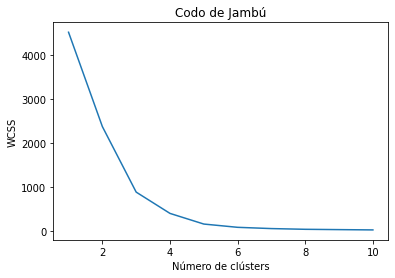

In [159]:
plt.plot(range(1, 11), wcss)
plt.title('Codo de Jambú')
plt.xlabel('Número de clústers')
plt.ylabel('WCSS') # WCSS es un indicador de qué tan similares son los individuos dentro de los clusters
plt.show()

El codo de Jambú nos indica la razón entre individuos y el número de clusters

Se elige el punto donde la gráfica deja de disminuir significativamente, en este caso fueron 3 clusters

## Aplicación de método k-means
La función "KMeans(n_clusters, max_iter)" y su método "fit(data)" se encarga de la lógica del algoritmo k-means, siendo la idea principal: ¿qué tan similares son los individuos dentro del cluster?

In [160]:
clustering = KMeans(n_clusters=3, max_iter=300) # crea el modelo
clustering.fit(coords_norm) # aplica el modelo a la base de datos

KMeans(n_clusters=3)

## Agregando clasificación a la data original

In [161]:
coords['KMeans_Clusters'] = clustering.labels_ # los resultos del clustering se guardan en labels_ dentro del modelo
coords.head()

id    latitud  longitud                   usuario  velocidad  \
0   1  40.831052 -1.086649  alexortizzzzzz@gmail.com        NaN   
1   2  40.831911 -1.087223  alexortizzzzzz@gmail.com        NaN   
2   3  40.832187 -1.087341  alexortizzzzzz@gmail.com        NaN   
3   4  40.832496 -1.087512  alexortizzzzzz@gmail.com        NaN   
4   5  40.832804 -1.087791  alexortizzzzzz@gmail.com        NaN   

   id_trayectoria  tiempo           transporte  \
0              20     NaN  Vehiculo particular   
1              20     NaN  Vehiculo particular   
2              20     NaN  Vehiculo particular   
3              20     NaN  Vehiculo particular   
4              20     NaN  Vehiculo particular   

                                                geom  KMeans_Clusters  
0  0101000020E61000009AB2D30FEA62F1BF40A374E95F6A...                2  
1  0101000020E61000001958C7F14365F1BF6117450F7C6A...                2  
2  0101000020E6100000569929ADBF65F1BF0394861A856A...                2  
3  0101000020E6100000EF1EA0FB7266F1BF81069B3A8F6A...                2  
4  0101000020E610000053211E899767F1BF2FFD4B52996A...                2

## Visualización de clusters formados
Se aplica el análisis de componentes principales para darnos una idea de como se formaron los clusters

Básicamente se aplican componentes principales porque la data original tiene varias columnas (componentes), y para ser presentada en un plano bidimensional es necesario dos componentes

En este sentido, se obtienen dos componentes que representan todas las columnas de la data

In [162]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(coords_norm)
pca_coords_df = pd.DataFrame(data=pca_coords, columns=['Componente_1', 'Componente_2'])
pca_coords_names = pd.concat([pca_coords_df, coords[['KMeans_Clusters']]], axis=1)

pca_coords_names

Componente_1  Componente_2  KMeans_Clusters
0         -0.065012      1.119212                2
1         -0.065025      1.119211                2
2         -0.065028      1.119212                2
3         -0.065033      1.119212                2
4         -0.065038      1.119211                2
...             ...           ...              ...
51832     -0.072320     -0.027112                0
51833     -0.072320     -0.027112                0
51834     -0.072320     -0.027112                0
51835     -0.072320     -0.027112                0
51836     -0.072320     -0.027112                0

[51837 rows x 3 columns]

Usando la librería matplotlib.pyplot (plt) se grafican los resultados

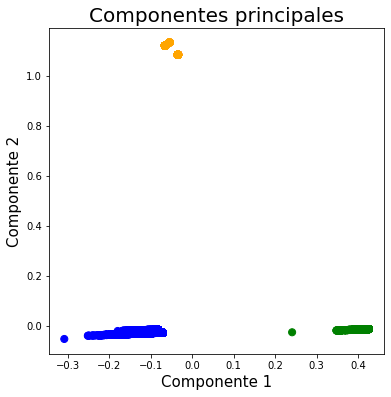

In [163]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Componente 1', fontsize=15)
ax.set_ylabel('Componente 2', fontsize=15)
ax.set_title('Componentes principales', fontsize=20)

color_theme = np.array(['blue', 'green', 'orange'])
ax.scatter(x=pca_coords_names.Componente_1, y=pca_coords_names.Componente_2,
           c=color_theme[pca_coords_names.KMeans_Clusters], s=50)
plt.show()